In [ ]:
#New updates 06/14/2024: get chip id for aborted chips, get wafer id, get date, print other errors on new line, fix code for multiple files, remove test_end
#New error messages must be added manually

Wafer ID: 04B1
Start date: 2024-06-24
------
There were 101 total error messages in 1 wafer. 16 were repeats and will not be shown below.
Number of scan chain errors: 8
Number of analog scan failures: 0
Number of digital scan failures: 2
Number of VDD errors: 2
Number of chips with dead pixels: 4
Number of DAQ function program terminations:0
Number of programming errors: 0
Number of DAQ digital scan errors: 2
Number of DAC calibration errors: 4
------
12 chip(s) did not complete testing (92, 34, 35, 26, 86, A7, D8, 8C, BC, 5E, 7F, 6F).
Total number of dead pixels: 44 (of 145152 in 1 wafer)
Other errors (0): 


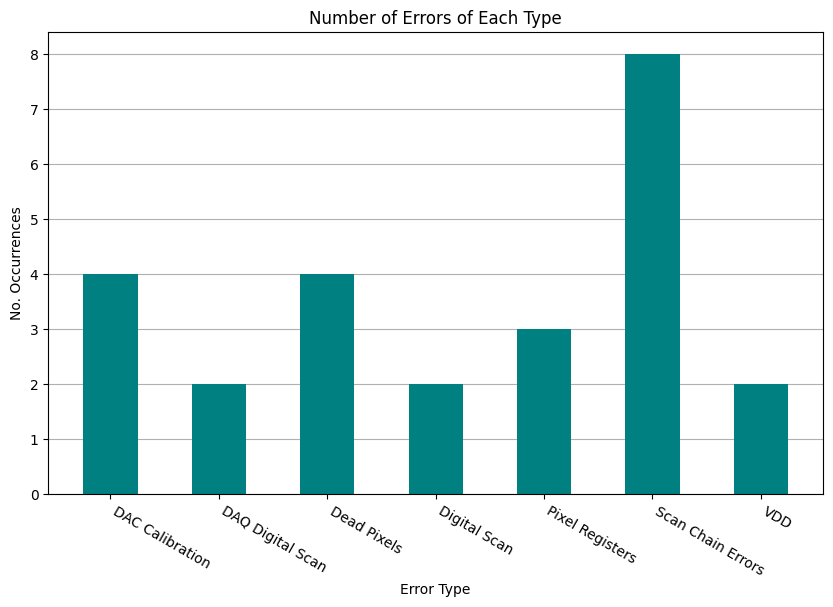

In [31]:
#Analyze errors of one file 
import re
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import numpy as np

#open file
with open(os.path.expanduser('~/Desktop/wafer_NC0W14-04B1_20240624_164933.log'), 'r') as file:
    log_content = file.readlines()

#Set up patterns
waferpattern = r'Wafer: (\w\w\w\w)'
waferid = ""
testabortpattern = r'Testing has been aborted for chip (.*)'
failedtestchips = []
pattern = r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) \| ChipTester \(\S\S\S\S\-(\w\w\)) \| ERROR    \| (.*)'
nochippattern = r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) \| .* \((\S\S\S\S).*\| ERROR    \| (.*)'

#Find errors, names of aborted chips, and wafer ID
chip = ()
errors1 = ()
errors = []
nochiperror = ()
nochiperrors = []
for line in log_content:
    match = re.search(pattern, line)
    nochipmatch = re.search(nochippattern, line)
    if match:
        chip = str(match.group(2)) 
        chip = chip.replace(")","")
        errors1 = match.group(3) 
        errors.append(chip+errors1)
        testabortmatch = re.search(testabortpattern, line)
        if testabortmatch:
            failedtestchips.append(testabortmatch.group(1))
    elif nochipmatch:
        if nochipmatch.group(3) != "Waferprobing has been aborted!":
            errors.append("AA" + nochipmatch.group(3))
    wafermatch = re.search(waferpattern, line)
    if wafermatch:
        waferid = str(wafermatch.group(1))
    
#Remove duplicate errors (for each chip)
errors = list(set(errors))
errors = [i[2:] for i in errors]

#Process aborted chip counter
failedtestchips = [i[12:] for i in failedtestchips]
failedtestchips = [i[:2] for i in failedtestchips]

#error counter
scan_chain = 0
analog_scan = 0
digital_scan = 0
vdd = 0
register_error = 0
daq_func_prog_term = 0
dead_pixels = 0
testing_aborted = 0
test_end = 0
prog_err = 0
pixel_register = 0
daq_digital = 0
daq_digital_2 = 0 #error message with the previous
dac_calibration = 0
dac_calibration_2 = 0 #error message with the previous
other_errors = []
pattern2 = r'Register .* failed the test'
pattern3 = r'Number of errors: .*'
xxx = 0
repeats = 0

#count each error type
for x in errors:
    match2 = re.search(pattern2, x)
    match3 = re.search(pattern3, x)
    match4 = re.search(testabortpattern, x)
    if 'Scan chain test failed!' in x:
        scan_chain = scan_chain + 1
    elif x==("Analog scan failed!"):
        analog_scan = analog_scan + 1
    elif x==("Digital scan failed!"):
        digital_scan = digital_scan + 1
    elif x==("DAQ function write_vdd_trim_bits terminated unexpectedly!") or 'VDD' in x:
        vdd = vdd + 1
    elif x==("Register W&R errors detected!"):
        register_error = register_error + 1
    elif x==("DAQ function program terminated unexpectedly!"):
        daq_func_prog_term = daq_func_prog_term + 1
    elif x==("Waferprobing has been aborted!"):
        test_end = test_end + 1
    elif x==("Could not program the chip!"):
        prog_err = prog_err + 1
    elif x==("Pixel registers test failed!"):
        pixel_register = pixel_register + 1
    elif x==("DAQ function digital_scan terminated unexpectedly!"):
        daq_digital = daq_digital + 1
    elif x==("DAQ function dac_calibration terminated unexpectedly!") or x==("DACs calibration failed!"):
        dac_calibration = dac_calibration + 1
    elif match2:
        dead_pixels = dead_pixels + 1
    elif match3:
        xxx = xxx + 1
    elif match4:
        testing_aborted = testing_aborted + 1
    elif x==("Aborting testing") or x==("Aborting testing!") or x==("Digital scan failed before completion!") or x==("Digital scan failed") or x==("Digital scan failed due to DAQ error!") or x==("DACs calibration failed! Continuing the testing...") or x==("Testing of pixel registers failed!") or x==("More than 150 register errors!") or x==("Failing pixel registers above online cut!"):
        repeats = repeats + 1
    else:
        other_errors.append(x)
    
#printing
print("Wafer ID: " + str(waferid))
print("Start date: " + str(str([log_content[0]])[:12][2:]))
print("------")
print(f'There were {str(len(errors)+len(nochiperrors))} total error messages in 1 wafer. {repeats} were repeats and will not be shown below.') 
print("Number of scan chain errors: " + str(scan_chain))
print("Number of analog scan failures: " + str(analog_scan))
print("Number of digital scan failures: " + str(digital_scan))
print("Number of VDD errors: " + str(vdd))
print("Number of chips with dead pixels: " + str(register_error))
print("Number of DAQ function program terminations:" + str(daq_func_prog_term))
print("Number of programming errors: " + str(prog_err))
print("Number of DAQ digital scan errors: " + str(daq_digital))
print("Number of DAC calibration errors: " + str(dac_calibration))
print("------")
if testing_aborted > 0:
    print(str(testing_aborted) + " chip(s) did not complete testing (" + ', '.join(failedtestchips) + ").")
elif testing_aborted == 0:
    print("All chips completed testing")
print("Total number of dead pixels: " + str(dead_pixels) + " (of 145152 in 1 wafer)")
print("Other errors (" + str(len(other_errors)) + "): ") 
for error in other_errors:
    print("   - " + str(error))

# Plot
data = {'Scan Chain Errors':scan_chain,'VDD':vdd,'Dead Pixels':register_error,'Digital Scan':digital_scan,'DAQ Func Prog Term':daq_func_prog_term,'DAQ Digital Scan':daq_digital,'Analog Scan':analog_scan,'DAC Calibration':dac_calibration,'Pixel Registers':pixel_register,'other':len(other_errors)}

alph_data = dict(sorted(data.items()))
clean_data = {k:v for k,v in alph_data.items() if v > 0}
labels = list(clean_data.keys())
values = list(clean_data.values())

fig = plt.figure(figsize = (10, 6))

# creating the bar plot
plt.bar(labels, values, color ='teal', 
        width = 0.5, zorder=2)
plt.grid(axis = 'y', zorder = 1)
plt.xlabel("Error Type")
plt.ylabel("No. Occurrences")
plt.title("Number of Errors of Each Type")
plt.xticks(rotation=-30, ha='left')
plt.show()

Wafer ID: 03B6
Start date: 2024-06-27
Wafer ID: 06H2
Start date: 2024-06-25
Wafer ID: 04B1
Start date: 2024-06-24
------
There were 317 total error messages and 158 actual errors in 1 wafer. 56 were repeats and will not be shown below.
Number of scan chain errors: 16
Number of analog scan failures: 3
Number of digital scan failures: 15
Number of VDD errors: 4
Number of chips with dead pixels: 17
Number of DAQ function program terminations: 0
Number of programming errors: 0
Number of DAQ digital scan errors: 15
Number of DAC calibration errors: 12
Number of temperature measurement errors: 0
Number of LDO measurement errors: 2
Number of IREF trimming failures: 6
Number of threshold scan failures: 0
Number of overvoltage trip errors: 1
Number of data merging errors: 0
------
Total number of dead pixels: 100 (of 435456 in 3 wafers)
Other errors (6): 
   - No data from registers test!
   - Testing of global registers failed!
   - The test could not be completed!
   - Measured values in SLDO

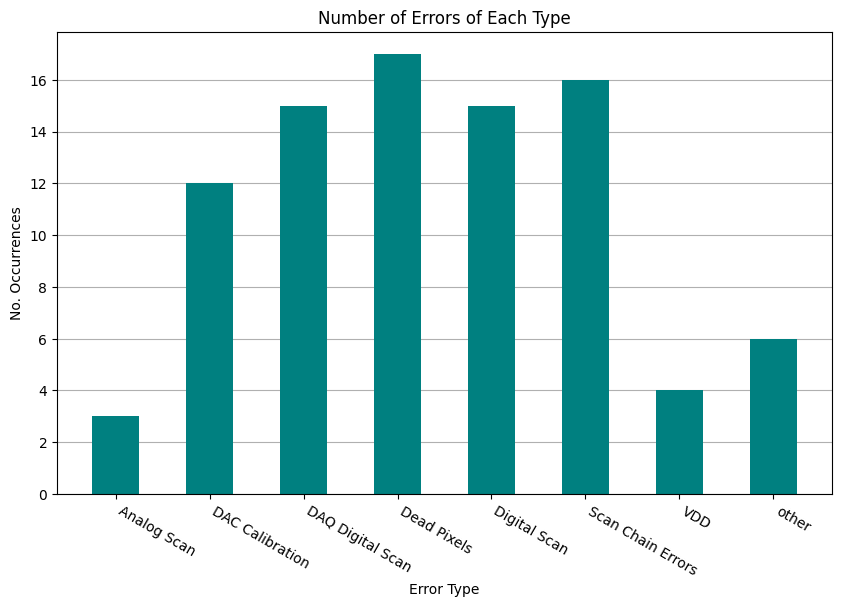

In [77]:
#Analyze errors of all files in a folder

import re
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import numpy as np

#Find errors, names of aborted chips, and wafer ID
chip = ()
errors1 = ()
errors = []
nochiperror = ()
nochiperrors = []
wafercount = 0

#Set up patterns
waferpattern = r'Wafer: (\w\w\w\w)'
waferid = ""
testabortpattern = r'Testing has been aborted for chip (.*)'
failedtestchips = []
pattern = r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) \| ChipTester \(\S\S\S\S\-(\w\w\)) \| ERROR    \| (.*)'
nochippattern = r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) \| .* \((\S\S\S\S).*\| ERROR    \| (.*)'
        
#open file
path = os.path.expanduser('~/Desktop/log_files/2nd_probe_card')
for file_name in os.listdir(path):
    if file_name.endswith(".log"):  #Check if the file is a .log file and specify chip
        file_path = os.path.join(path, file_name)
        wafercount = wafercount + 1
        with open(file_path, 'r') as file:
            log_content = file.readlines()
        
        #Find errors, names of aborted chips, and wafer ID
        for line in log_content:
            match = re.search(pattern, line)
            nochipmatch = re.search(nochippattern, line)
            if match:
                chip = str(match.group(2)) 
                chip = chip.replace(")","")
                errors1 = match.group(3) 
                errors.append(chip+errors1)
                testabortmatch = re.search(testabortpattern, line)
                if testabortmatch:
                    failedtestchips.append(testabortmatch.group(1))
            elif nochipmatch:
                if nochipmatch.group(3) != "Waferprobing has been aborted!":
                    errors.append("AA" + nochipmatch.group(3))
            wafermatch = re.search(waferpattern, line)
            if wafermatch:
                waferid = str(wafermatch.group(1))
        print("Wafer ID: " + str(waferid))
        print("Start date: " + str(str([log_content[0]])[:12][2:]))
        
#Remove duplicate errors (for each chip)
errors = list(set(errors))
errors = [i[2:] for i in errors]

#Process aborted chip counter
failedtestchips = [i[12:] for i in failedtestchips]
failedtestchips = [i[:2] for i in failedtestchips]

#error counter
real_errors = 0
scan_chain = 0
analog_scan = 0
digital_scan = 0
vdd = 0
register_error = 0
daq_func_prog_term = 0
dead_pixels = 0
testing_aborted = 0
test_end = 0
prog_err = 0
pixel_register = 0
daq_digital = 0
daq_digital_2 = 0 #error message with the previous
dac_calibration = 0
dac_calibration_2 = 0 #error message with the previous
temps = 0
ldo = 0
iref = 0
threshold = 0
overvoltage = 0
data_merging = 0
other_errors = []
pattern2 = r'Register .* failed the test'
pattern3 = r'Number of errors: .*'
xxx = 0
repeats = 0

#count each error type
for x in errors:
    match2 = re.search(pattern2, x)
    match3 = re.search(pattern3, x)
    match4 = re.search(testabortpattern, x)
    if 'Scan chain test failed!' in x:
        scan_chain = scan_chain + 1
        real_errors = real_errors + 1
    elif x==("Analog scan failed!"):
        analog_scan = analog_scan + 1
        real_errors = real_errors + 1
    elif x==("Digital scan failed!"):
        digital_scan = digital_scan + 1
        real_errors = real_errors + 1
    elif x==("DAQ function write_vdd_trim_bits terminated unexpectedly!") or 'VDD' in x:
        vdd = vdd + 1
        real_errors = real_errors + 1
    elif x==("Register W&R errors detected!"):
        register_error = register_error + 1
        real_errors = real_errors + 1
    elif x==("DAQ function program terminated unexpectedly!"):
        daq_func_prog_term = daq_func_prog_term + 1
        real_errors = real_errors + 1
    elif x==("Waferprobing has been aborted!"):
        test_end = test_end + 1
        real_errors = real_errors + 1
    elif x==("Could not program the chip!"):
        prog_err = prog_err + 1
        real_errors = real_errors + 1
    elif x==("Pixel registers test failed!"):
        pixel_register = pixel_register + 1
        real_errors = real_errors + 1
    elif x==("DAQ function digital_scan terminated unexpectedly!"):
        daq_digital = daq_digital + 1
        real_errors = real_errors + 1
    elif x==("DAQ function dac_calibration terminated unexpectedly!") or x==("DACs calibration failed!"):
        dac_calibration = dac_calibration + 1
        real_errors = real_errors + 1
    elif x==("Could not measure chip temperatures!"):
        temps = temps + 1
        real_errors = real_errors + 1
    elif x==("Measured values in LDO mode not within tolerance!"):
        ldo = ldo + 1
        real_errors = real_errors + 1
    elif x==("IREF trimming failed online selection!"):
        iref = iref + 1
        real_errors = real_errors + 1
    elif x==("Threshold scan failed!"):
        threshold = threshold + 1
        real_errors = real_errors + 1
    elif x==("A chip trip condition has been detected! Digital power: ['overvoltage_trip']"):
        overvoltage = overvoltage + 1
        real_errors = real_errors + 1
    elif x==("Data merging test failed!"):
        data_merging = data_merging + 1
        real_errors = real_errors + 1
    elif match2:
        dead_pixels = dead_pixels + 1
    elif match3:
        xxx = xxx + 1
    elif match4:
        testing_aborted = testing_aborted + 1
    elif x==("Aborting testing") or x==("Digital scan failed online cuts!") or x==("Aborting testing!") or x==("Digital scan failed before completion!") or x==("Analog scan failed online cuts!") or x==("Coarse threshold scan failed!") or x==("Threshold scan failed due to DAQ error!") or x==("DAQ function read_temperature terminated unexpectedly!") or x==("Digital scan failed") or x==("Digital scan failed due to DAQ error!") or x==("DACs calibration failed! Continuing the testing...") or x==("Testing of pixel registers failed!") or x==("More than 150 register errors!") or x==("Failing pixel registers above online cut!") or x==("DAQ function threshold_scan terminated unexpectedly!"):
        repeats = repeats + 1
        real_errors = real_errors + 1
    else:
        other_errors.append(x)
        real_errors = real_errors + 1
    
#printing
print("------")
print(f'There were {str(len(errors)+len(nochiperrors))} total error messages and {real_errors} actual errors in 1 wafer. {repeats} were repeats and will not be shown below.') 
print("Number of scan chain errors: " + str(scan_chain))
print("Number of analog scan failures: " + str(analog_scan))
print("Number of digital scan failures: " + str(digital_scan))
print("Number of VDD errors: " + str(vdd))
print("Number of chips with dead pixels: " + str(register_error))
print("Number of DAQ function program terminations: " + str(daq_func_prog_term))
print("Number of programming errors: " + str(prog_err))
print("Number of DAQ digital scan errors: " + str(daq_digital))
print("Number of DAC calibration errors: " + str(dac_calibration))
print("Number of temperature measurement errors: " + str(temps))
print("Number of LDO measurement errors: " + str(ldo))
print("Number of IREF trimming failures: " + str(iref))
print("Number of threshold scan failures: " + str(threshold))
print("Number of overvoltage trip errors: " + str(overvoltage))
print("Number of data merging errors: " + str(data_merging))
print("------")
if testing_aborted > 0:
    testing_message = f"{testing_aborted} chip(s) did not complete testing (chip ID(s): {', '.join(failedtestchips)})."
elif testing_aborted == 0:
    testing_message = "All chips completed testing"
print("Total number of dead pixels: " + str(dead_pixels) + " (of " + str(145152*wafercount) + " in " + str(wafercount) + " wafers)")
print("Other errors (" + str(len(other_errors)) + "): ") 
for error in other_errors:
    print("   - " + str(error))

# Plot
data = {'Scan Chain Errors':scan_chain,'VDD':vdd,'Dead Pixels':register_error,'Digital Scan':digital_scan,'DAQ Func Prog Term':daq_func_prog_term,'DAQ Digital Scan':daq_digital,'Analog Scan':analog_scan,'DAC Calibration':dac_calibration,'other':len(other_errors)}
alph_data = dict(sorted(data.items()))
clean_data = {k:v for k,v in alph_data.items() if v > 0}
labels = list(clean_data.keys())
values = list(clean_data.values())
  
fig = plt.figure(figsize = (10, 6))
 
# creating the bar plot
plt.bar(labels, values, color ='teal', 
        width = 0.5, zorder=2)

plt.grid(axis = 'y', zorder = 1)
plt.xlabel("Error Type")
plt.ylabel("No. Occurrences")
plt.title("Number of Errors of Each Type")
plt.xticks(rotation=-30, ha='left')
plt.show()


Wafer ID: 04B1
Start date: 2024-06-24
------
There were 101 total error messages and 41 actual errors in 1 wafer. 16 were repeats and will not be shown below.
Number of scan chain errors: 8
Number of analog scan failures: 0
Number of digital scan failures: 2
Number of VDD errors: 2
Number of chips with dead pixels: 4
Number of DAQ function program terminations: 0
Number of programming errors: 0
Number of DAQ digital scan errors: 2
Number of DAC calibration errors: 4
Number of temperature measurement errors: 0
Number of LDO measurement errors: 0
Number of IREF trimming failures: 0
Number of threshold scan failures: 0
Number of overvoltage trip errors: 0
Number of data merging errors: 0
------
Total number of dead pixels: 44 (of 435456 in 3 wafers)
Other errors (0): 


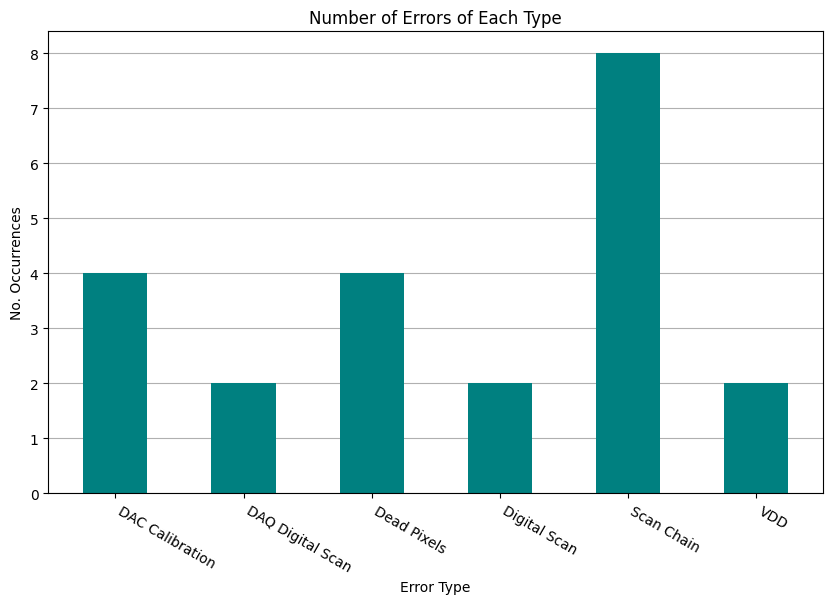

Wafer ID: 06H2
Start date: 2024-06-25
------
There were 113 total error messages and 62 actual errors in 1 wafer. 23 were repeats and will not be shown below.
Number of scan chain errors: 6
Number of analog scan failures: 1
Number of digital scan failures: 7
Number of VDD errors: 0
Number of chips with dead pixels: 8
Number of DAQ function program terminations: 0
Number of programming errors: 0
Number of DAQ digital scan errors: 7
Number of DAC calibration errors: 4
Number of temperature measurement errors: 0
Number of LDO measurement errors: 2
Number of IREF trimming failures: 2
Number of threshold scan failures: 0
Number of overvoltage trip errors: 0
Number of data merging errors: 0
------
Total number of dead pixels: 29 (of 435456 in 3 wafers)
Other errors (0): 


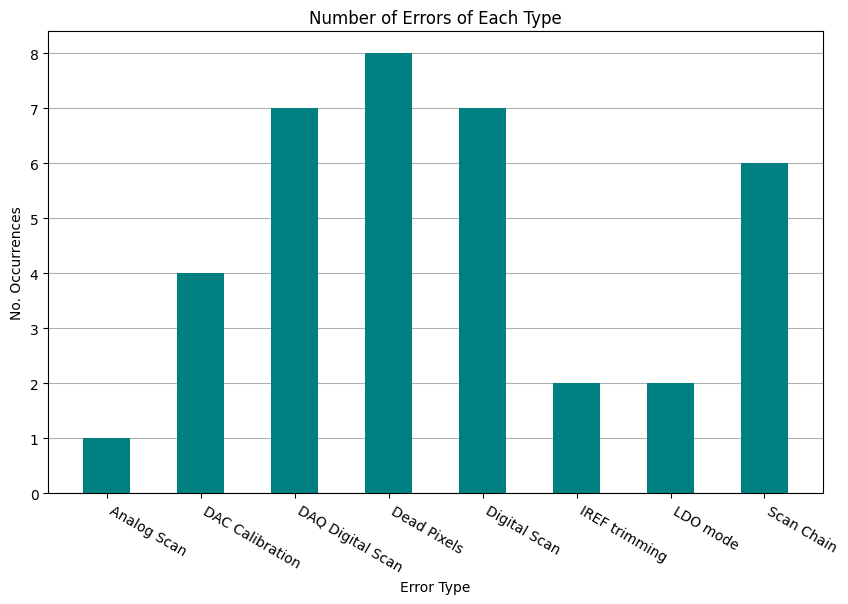

Wafer ID: 03B6
Start date: 2024-06-27
------
There were 128 total error messages and 61 actual errors in 1 wafer. 20 were repeats and will not be shown below.
Number of scan chain errors: 2
Number of analog scan failures: 2
Number of digital scan failures: 6
Number of VDD errors: 2
Number of chips with dead pixels: 7
Number of DAQ function program terminations: 0
Number of programming errors: 0
Number of DAQ digital scan errors: 6
Number of DAC calibration errors: 4
Number of temperature measurement errors: 0
Number of LDO measurement errors: 0
Number of IREF trimming failures: 4
Number of threshold scan failures: 0
Number of overvoltage trip errors: 1
Number of data merging errors: 0
------
Total number of dead pixels: 46 (of 435456 in 3 wafers)
Other errors (6): 
   - Measured values in SLDO mode not within tolerance!
   - Testing of global registers failed!
   - No data from registers test!
   - DAQ function global_registers_test terminated unexpectedly!
   - Caught exception from r

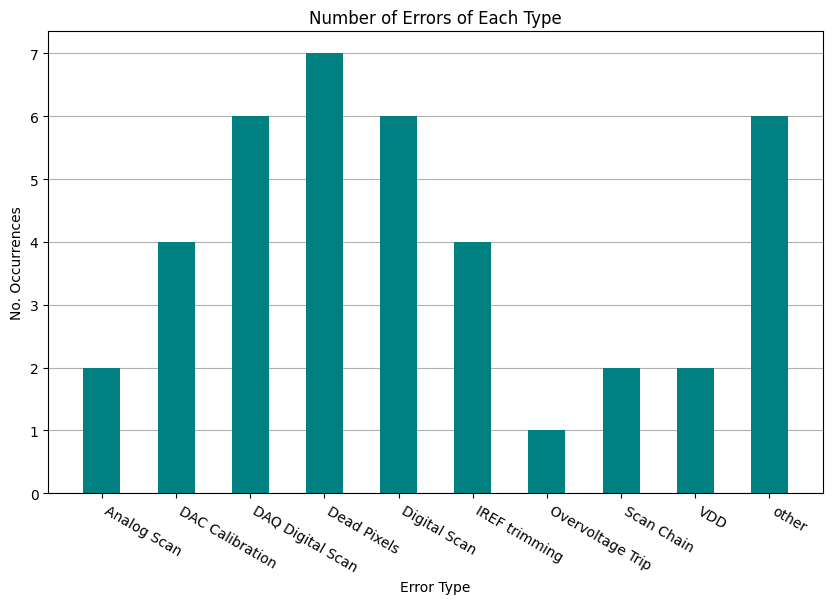

In [83]:
#multiple files and separate stats for each one
import re
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import numpy as np

#open file
path = os.path.expanduser('~/Desktop/log_files/2nd_probe_card')
pattern = r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) \| .*ERROR    \| (.*)' 

#Open files in chronological order
files = [(file, os.path.getmtime(os.path.join(path, file))) for file in os.listdir(path)]
files.sort(key=lambda x: x[1])
for file_name, modification_time in files:
    if file_name.endswith(".log"):  #Check if the file is a .log file and specify chip
        file_path = os.path.join(path, file_name)
        with open(file_path, 'r') as file:
            log_content = file.readlines()

        #Set up patterns
        waferpattern = r'Wafer: (\w\w\w\w)'
        waferid = ""
        testabortpattern = r'Testing has been aborted for chip (.*)'
        failedtestchips = []
        pattern = r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) \| ChipTester \(\S\S\S\S\-(\w\w\)) \| ERROR    \| (.*)'
        nochippattern = r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) \| .* \((\S\S\S\S).*\| ERROR    \| (.*)'
        
        #Find errors, names of aborted chips, and wafer ID
        chip = ()
        errors1 = ()
        errors = []
        nochiperror = ()
        nochiperrors = []
        for line in log_content:
            match = re.search(pattern, line)
            nochipmatch = re.search(nochippattern, line)
            if match:
                chip = str(match.group(2)) 
                chip = chip.replace(")","")
                errors1 = match.group(3) 
                errors.append(chip+errors1)
                testabortmatch = re.search(testabortpattern, line)
                if testabortmatch:
                    failedtestchips.append(testabortmatch.group(1))
            elif nochipmatch:
                if nochipmatch.group(3) != "Waferprobing has been aborted!":
                    errors.append("AA" + nochipmatch.group(3))
            wafermatch = re.search(waferpattern, line)
            if wafermatch:
                waferid = str(wafermatch.group(1))
            
        print("Wafer ID: " + str(waferid))
        print("Start date: " + str(str([log_content[0]])[:12][2:]))
        
        #Remove duplicate errors (for each chip)
        errors = list(set(errors))
        errors = [i[2:] for i in errors]
        
        #Process aborted chip counter
        failedtestchips = [i[12:] for i in failedtestchips]
        failedtestchips = [i[:2] for i in failedtestchips]
        
        #error counter
        real_errors = 0
        scan_chain = 0
        analog_scan = 0
        digital_scan = 0
        vdd = 0
        register_error = 0
        daq_func_prog_term = 0
        dead_pixels = 0
        testing_aborted = 0
        test_end = 0
        prog_err = 0
        pixel_register = 0
        daq_digital = 0
        daq_digital_2 = 0 #error message with the previous
        dac_calibration = 0
        dac_calibration_2 = 0 #error message with the previous
        temps = 0
        ldo = 0
        iref = 0
        threshold = 0
        overvoltage = 0
        data_merging = 0
        other_errors = []
        pattern2 = r'Register .* failed the test'
        pattern3 = r'Number of errors: .*'
        xxx = 0
        repeats = 0

        #count each error type
        for x in errors:
            match2 = re.search(pattern2, x)
            match3 = re.search(pattern3, x)
            match4 = re.search(testabortpattern, x)
            if 'Scan chain test failed!' in x:
                scan_chain = scan_chain + 1
                real_errors = real_errors + 1
            elif x==("Analog scan failed!"):
                analog_scan = analog_scan + 1
                real_errors = real_errors + 1
            elif x==("Digital scan failed!"):
                digital_scan = digital_scan + 1
                real_errors = real_errors + 1
            elif x==("DAQ function write_vdd_trim_bits terminated unexpectedly!") or 'VDD' in x:
                vdd = vdd + 1
                real_errors = real_errors + 1
            elif x==("Register W&R errors detected!"):
                register_error = register_error + 1
                real_errors = real_errors + 1
            elif x==("DAQ function program terminated unexpectedly!"):
                daq_func_prog_term = daq_func_prog_term + 1
                real_errors = real_errors + 1
            elif x==("Waferprobing has been aborted!"):
                test_end = test_end + 1
                real_errors = real_errors + 1
            elif x==("Could not program the chip!"):
                prog_err = prog_err + 1
                real_errors = real_errors + 1
            elif x==("Pixel registers test failed!"):
                pixel_register = pixel_register + 1
                real_errors = real_errors + 1
            elif x==("DAQ function digital_scan terminated unexpectedly!"):
                daq_digital = daq_digital + 1
                real_errors = real_errors + 1
            elif x==("DAQ function dac_calibration terminated unexpectedly!") or x==("DACs calibration failed!"):
                dac_calibration = dac_calibration + 1
                real_errors = real_errors + 1
            elif x==("Could not measure chip temperatures!"):
                temps = temps + 1
                real_errors = real_errors + 1
            elif x==("Measured values in LDO mode not within tolerance!"):
                ldo = ldo + 1
                real_errors = real_errors + 1
            elif x==("IREF trimming failed online selection!"):
                iref = iref + 1
                real_errors = real_errors + 1
            elif x==("Threshold scan failed!"):
                threshold = threshold + 1
                real_errors = real_errors + 1
            elif x==("A chip trip condition has been detected! Digital power: ['overvoltage_trip']"):
                overvoltage = overvoltage + 1
                real_errors = real_errors + 1
            elif x==("Data merging test failed!"):
                data_merging = data_merging + 1
                real_errors = real_errors + 1
            elif match2:
                dead_pixels = dead_pixels + 1
            elif match3:
                xxx = xxx + 1
            elif match4:
                testing_aborted = testing_aborted + 1
            elif x==("Aborting testing") or x==("Digital scan failed online cuts!") or x==("Aborting testing!") or x==("Digital scan failed before completion!") or x==("Analog scan failed online cuts!") or x==("Coarse threshold scan failed!") or x==("Threshold scan failed due to DAQ error!") or x==("DAQ function read_temperature terminated unexpectedly!") or x==("Digital scan failed") or x==("Digital scan failed due to DAQ error!") or x==("DACs calibration failed! Continuing the testing...") or x==("Testing of pixel registers failed!") or x==("More than 150 register errors!") or x==("Failing pixel registers above online cut!") or x==("DAQ function threshold_scan terminated unexpectedly!"):
                repeats = repeats + 1
                real_errors = real_errors + 1
            else:
                other_errors.append(x)
                real_errors = real_errors + 1

        #printing
        print("------")
        print(f'There were {str(len(errors)+len(nochiperrors))} total error messages and {real_errors} actual errors in 1 wafer. {repeats} were repeats and will not be shown below.') 
        print("Number of scan chain errors: " + str(scan_chain))
        print("Number of analog scan failures: " + str(analog_scan))
        print("Number of digital scan failures: " + str(digital_scan))
        print("Number of VDD errors: " + str(vdd))
        print("Number of chips with dead pixels: " + str(register_error))
        print("Number of DAQ function program terminations: " + str(daq_func_prog_term))
        print("Number of programming errors: " + str(prog_err))
        print("Number of DAQ digital scan errors: " + str(daq_digital))
        print("Number of DAC calibration errors: " + str(dac_calibration))
        print("Number of temperature measurement errors: " + str(temps))
        print("Number of LDO measurement errors: " + str(ldo))
        print("Number of IREF trimming failures: " + str(iref))
        print("Number of threshold scan failures: " + str(threshold))
        print("Number of overvoltage trip errors: " + str(overvoltage))
        print("Number of data merging errors: " + str(data_merging))
        print("------")
        if testing_aborted > 0:
            testing_message = f"{testing_aborted} chip(s) did not complete testing (chip ID(s): {', '.join(failedtestchips)})."
        elif testing_aborted == 0:
            testing_message = "All chips completed testing"
        print("Total number of dead pixels: " + str(dead_pixels) + " (of " + str(145152*wafercount) + " in " + str(wafercount) + " wafers)")
        print("Other errors (" + str(len(other_errors)) + "): ") 
        for error in other_errors:
            print("   - " + str(error))
        
        # Plot
        data = {'Scan Chain':scan_chain,'VDD':vdd,'Dead Pixels':register_error,'Digital Scan':digital_scan,'DAQ Func Prog Term':daq_func_prog_term,'Temperature Measurement':temps,'Data Merging':data_merging,'Overvoltage Trip':overvoltage,'Threshold Scan':threshold,'IREF trimming':iref,'LDO mode':ldo,'DAQ Digital Scan':daq_digital,'Analog Scan':analog_scan,'DAC Calibration':dac_calibration,'other':len(other_errors)}
        
        alph_data = dict(sorted(data.items()))
        clean_data = {k:v for k,v in alph_data.items() if v > 0}
        labels = list(clean_data.keys())
        values = list(clean_data.values())
        
        fig = plt.figure(figsize = (10, 6))
        
        # creating the bar plot
        plt.bar(labels, values, color ='teal', 
                width = 0.5, zorder=2)
        
        plt.grid(axis = 'y', zorder = 1)
        plt.xlabel("Error Type")
        plt.ylabel("No. Occurrences")
        plt.title("Number of Errors of Each Type")
        plt.xticks(rotation=-30, ha='left')
        plt.show()    